In [1]:
import time
import copy
import torch
import torch_geometric

from torch import nn, optim
from torch.nn import functional as F
from torch_geometric import nn as gnn
from torch.utils.data import DataLoader
from torch_geometric.datasets import ModelNet
from IPython.display import display, clear_output
from torch_geometric.utils import remove_self_loops
from sklearn.model_selection import train_test_split

import os
import trimesh
import numpy as np
import matplotlib.pyplot as plt


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
print(torch.cuda.memory_allocated())
torch.cuda.memory_reserved()

0


0

In [4]:
# n = 1_000_000_000
# x = torch.rand(n)
# x = x.to(device)


In [5]:
# x = x.to('cpu')

# del x
# torch.cuda.empty_cache()

In [6]:
class_names = [
    'bathtub', 'bed', 'chair', 'desk', 'dresser', 
    'monitor', 'night_stand', 'sofa', 'table', 'toilet'
]

In [7]:
dataset = ModelNet('ModelNet/', name='10')

In [8]:
NUM_CLASSES = dataset.num_classes
# BATCH_SIZE = 128

In [9]:
sample = trimesh.load(os.path.join(os.getcwd(), 'ModelNet\\raw\\table\\train\\table_0362.off'))
sample.show()

In [10]:
points = sample.sample(2048)

In [11]:
def plot_points(points):
	fig, ax = plt.subplots(figsize=(16, 9))

	plot = fig.add_subplot(projection='3d')
	plot.scatter(points[:, 0], points[:, 1], points[:, 2])
	plt.show()

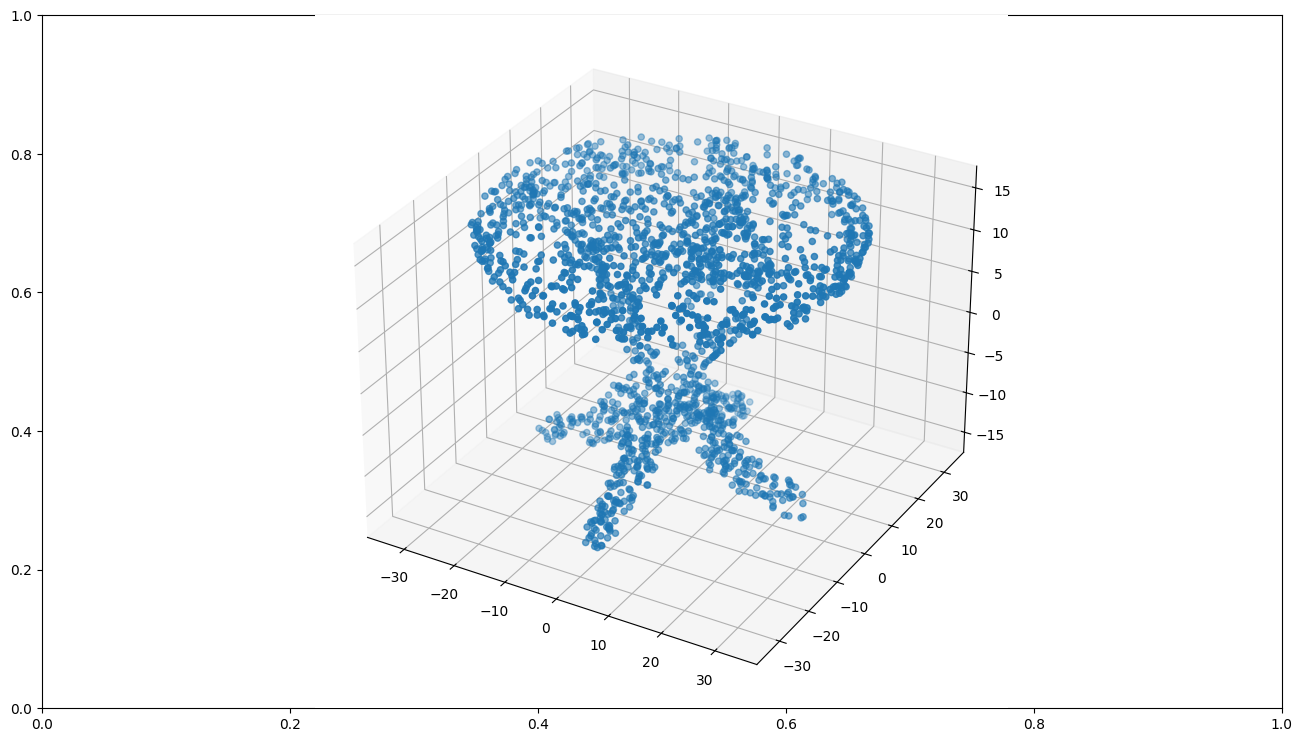

In [12]:
plot_points(points)

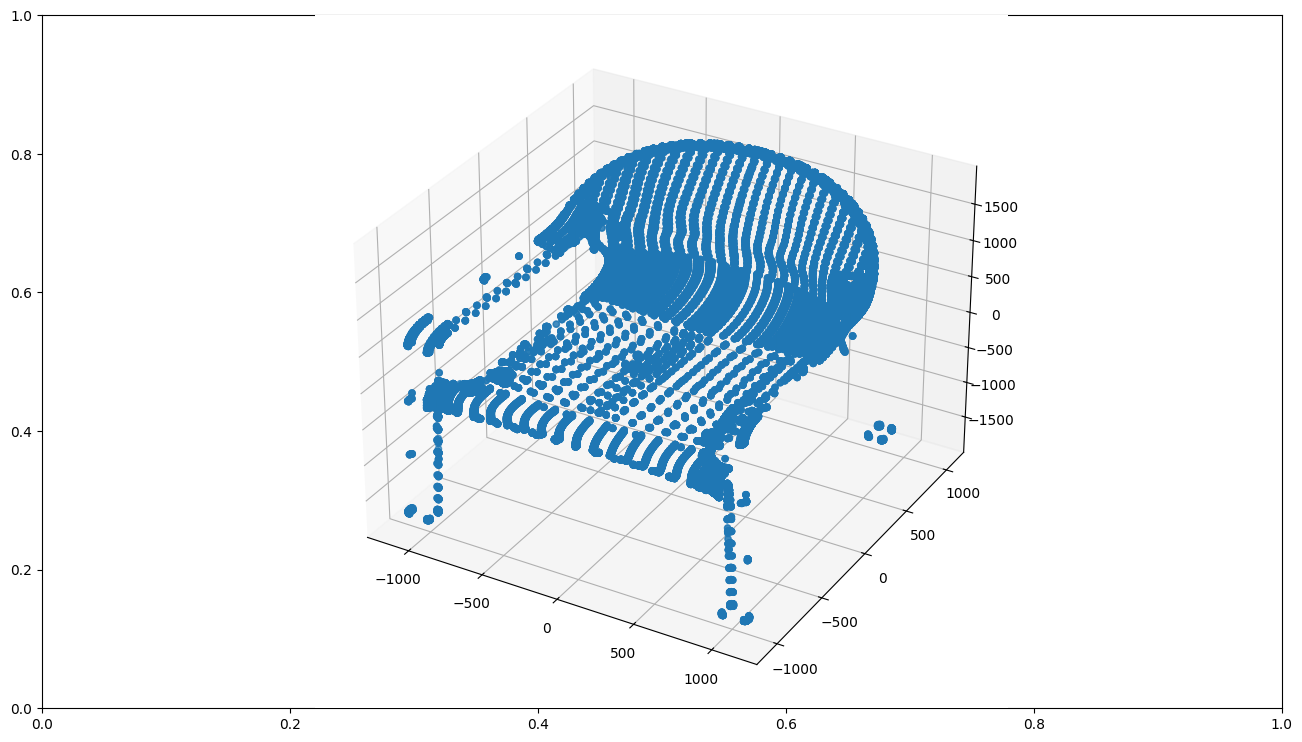

In [13]:
plot_points(dataset[900].pos)

In [16]:
class GNN(nn.Module):
	def __init__(self,
		data,
		hidden_channels,
		aggr='mean',
		lr=.1, 
		weight_decay=.01,
		batch_size=512,
		criterion=None):

		super(GNN, self).__init__()

		self.in_channels = data[0].pos.shape[1]
		self.num_classes = data.num_classes
		self.batch_size = batch_size
		n_heads = 1
		
		self.encoder_1 = gnn.SAGEConv(
				in_channels=self.in_channels,
				out_channels=hidden_channels,
				aggr=aggr,
			)
		 
		self.encoder_last = gnn.SAGEConv(
				in_channels=hidden_channels,
				out_channels=hidden_channels // 2,
				aggr=aggr
			)

		self.relu = nn.ReLU()
		
		# self.encoder = gnn.SAGEConv(
		# 	in_channels=self.in_channels,
		# 	out_channels=hidden_channels,
		# 	aggr=aggr,
		# )

		self.decoder = nn.Sequential(
			nn.Linear(
				self.encoder_last.out_channels * 2, 
				self.num_classes
			),
			# nn.Softmax(dim=-1),
		)

		self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)
		self.criterion = criterion if criterion else nn.CrossEntropyLoss()
		self.reset_metrics()

	def forward(self, x):
		x = x.to(device)

		face = x.face
		edge_index, _ = remove_self_loops(torch.cat([face[:2], face[1:], face[[0, 2]]], dim=1))

		x = self.encoder_1(x.pos, edge_index)
		# x = self.relu(x)
		# x = self.encoder_last(x, edge_index)
		# x = self.relu(x)
		
		x = x.sum(dim=0) / x.shape[0]
		
		x = self.decoder(x)
		
		return x, x.argmax()
	

	def predict(self, x):
		return class_names[self.forward(x)[1]]
	

	def accuracy(self, y, y_hat):
		return sum(y == y_hat) / y.shape[0]

	def reset_metrics(self):
		self.metrics = {
			'loss': [],
			'train_acc': [],
			'val_acc': []
		}

	def train_model(self,
				 data,
				 n_epochs,
				 per_epoch_permute=True,
				 validate=True,
				 train_split=.8,
				 plot=False):
		
		self.train()

		if plot:
			# fig = plt.figure()
			# ax = fig.add_subplot(111)
			fig, (ax, loss_ax) = plt.subplots(1, 2, figsize=(16, 9))

		if validate:
			data = data[torch.randperm(len(data))]
			print(f'{len(data)} => ', end='')
			n_train = int(train_split * len(data))
			data, val_data = data[:n_train], data[n_train:]
			print(f'({len(data)}, {len(val_data)})')
		
		ttime = 0
		for epoch in range(n_epochs):
			ts = time.time()
			loss = 0
			
			if per_epoch_permute:
				data = data[torch.randperm(len(data))]

			train_acc = 0

			for obj_idx, obj in enumerate(data):	
				o, y_hat = self(obj)
				y = torch.zeros(self.num_classes)
				y[obj.y] = 1
				y = y.to(device)

				loss = loss + self.criterion(o, y)
				
				train_acc += 1 if y_hat == obj.y else 0

				# # batch loss
				# if (((obj_idx % self.batch_size) == 0) and (obj_idx > 0)) or (obj_idx == (len(data) - 1)):
				# 	self.optim.zero_grad()
				# 	loss.backward()
				# 	self.optim.step()

			train_acc = train_acc / len(data)
			loss = loss / len(data)

			self.optim.zero_grad()
			loss.backward()
			self.optim.step()

			self.metrics['loss'].append(loss.detach().item())

			# loss.detach()


			# train_acc = self.accuracy(y, y_hat)
			self.metrics['train_acc'].append(train_acc)


			# Validate on validation data
			val_acc = -1
			if validate:
				with torch.no_grad():
					self.eval()

					val_acc = 0
					for obj in val_data:
						o, y_hat = self(obj)						
						val_acc += 1 if y_hat == obj.y else 0
					
					val_acc = val_acc / len(val_data)
					self.metrics['val_acc'].append(val_acc)
			
			ttime = ttime + (time.time() - ts)

			if plot:
				ax.clear()
				clear_output()
				ax.plot(self.metrics['train_acc'], label='train accuracy')
				ax.plot(self.metrics['val_acc'], label='validation accuracy')
				# ax.set_ylim((0, 1))
				ax.legend()

				loss_ax.clear()
				clear_output()
				loss_ax.plot(self.metrics['loss'], label='loss')
				loss_ax.legend()

				display(fig)
				plt.pause(0.2)

			if not plot:
				if (epoch == 0) or ((epoch + 1) % (n_epochs / 10) == 0):
					str_print = f'[{epoch + 1}/{n_epochs}]: loss - {loss.item():.4f}, train accuracy - {train_acc:.4f}, val accuracy - {val_acc:.4f}, avg time - {ttime / (n_epochs / 10):.3f}'
					print(str_print + ' ' * max(100 - len(str_print), 0), end='\n')
					ttime = 0

			if train_acc >= .9 and val_acc >= .9:
				print(" " * 100, end='\r')
				return self.metrics

		print(" " * 100, end='\r')
		return self.metrics





In [17]:
dataset = ModelNet('ModelNet/', name='10')
# dataset = dataset.to(device)

In [18]:
model = GNN(dataset, 100)
model = model.to(device)
model

GNN(
  (encoder_1): SAGEConv(3, 100, aggr=mean)
  (encoder_last): SAGEConv(100, 50, aggr=mean)
  (relu): ReLU()
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=10, bias=True)
  )
  (criterion): CrossEntropyLoss()
)

In [19]:
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated())
print(torch.cuda.memory_reserved())


49664
2097152


In [20]:
idx = 0

x = dataset[idx].to(device)
o = model.predict(x)
print(f'prediction on object at idx={idx}, predicted label={o}, actual label={class_names[dataset[idx].y]}')

del x
torch.cuda.empty_cache()

prediction on object at idx=0, predicted label=dresser, actual label=bathtub


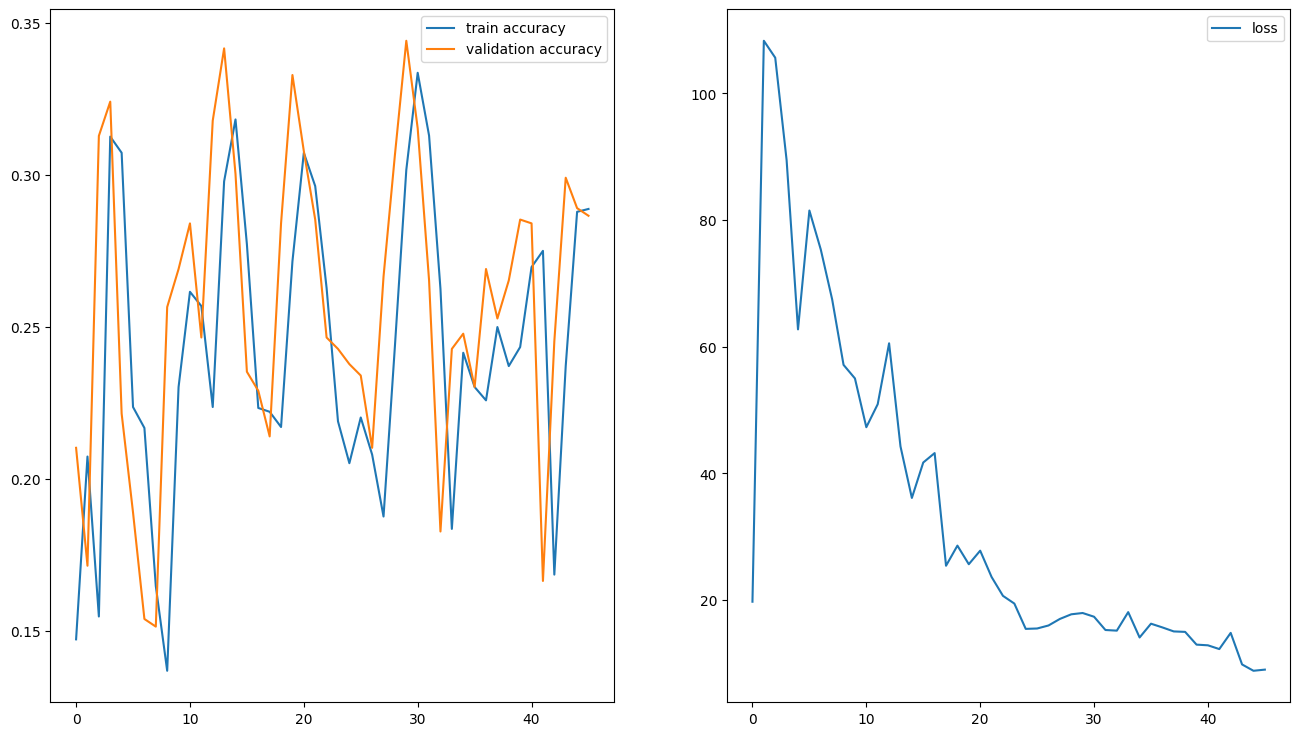

KeyboardInterrupt: 

In [22]:
model.train_model(dataset, 300, plot=True, validate=True)

In [ ]:
# torch.save(model.state_dict(), 'model.pkl')

In [ ]:
# metrics = {'loss': [7350.3447265625,
#   7001.4970703125,
#   6863.34814453125,
#   6700.55712890625,
#   6633.85009765625,
#   6550.1767578125,
#   6476.24072265625,
#   6461.263671875,
#   6417.12353515625,
#   6389.32763671875,
#   6390.5869140625,
#   6381.74951171875,
#   6381.95703125,
#   6391.478515625,
#   6343.474609375,
#   6312.28564453125,
#   6305.1689453125,
#   6314.41748046875,
#   6319.0556640625,
#   6310.83056640625,
#   6296.79931640625,
#   6294.9794921875,
#   6293.5439453125,
#   6285.75927734375,
#   6276.9521484375,
#   6269.87353515625,
#   6295.47265625,
#   6283.8759765625,
#   6259.20556640625,
#   6285.18603515625,
#   6278.23095703125,
#   6250.0732421875,
#   6249.783203125,
#   6248.94091796875,
#   6238.673828125,
#   6233.1787109375,
#   6218.17919921875,
#   6215.810546875,
#   6209.29443359375,
#   6211.9599609375,
#   6208.1279296875,
#   6207.79931640625,
#   6209.83251953125,
#   6206.2568359375,
#   6206.8427734375,
#   6204.869140625,
#   6203.083984375,
#   6197.58349609375,
#   6193.62939453125,
#   6193.07958984375,
#   6189.306640625,
#   6188.9296875,
#   6187.0771484375,
#   6183.2587890625,
#   6179.72705078125,
#   6170.0283203125,
#   6168.5078125,
#   6179.9287109375,
#   6201.76318359375,
#   6201.6767578125,
#   6192.11962890625,
#   6188.6611328125,
#   6180.50244140625,
#   6181.14990234375,
#   6178.05615234375,
#   6173.44873046875,
#   6172.453125,
#   6169.2392578125,
#   6165.0947265625,
#   6169.07470703125,
#   6171.63427734375,
#   6164.53759765625,
#   6162.75390625,
#   6161.8330078125,
#   6159.318359375,
#   6159.47412109375,
#   6154.40673828125,
#   6155.408203125,
#   6155.01708984375,
#   6149.79638671875,
#   6147.34912109375,
#   6147.61181640625,
#   6144.353515625,
#   6142.94140625,
#   6142.27001953125,
#   6140.8251953125,
#   6144.65380859375,
#   6140.53759765625,
#   6142.583984375,
#   6141.68505859375,
#   6146.2841796875,
#   6148.50439453125,
#   6142.56494140625,
#   6144.5283203125,
#   6141.65185546875,
#   6140.4287109375,
#   6139.4423828125,
#   6137.87646484375,
#   6139.80810546875,
#   6136.4140625,
#   6137.20556640625,
#   6139.4404296875,
#   6132.24560546875,
#   6132.779296875,
#   6135.8701171875,
#   6134.6904296875,
#   6132.59619140625,
#   6131.49658203125,
#   6131.32861328125,
#   6129.6298828125],
#  'train_acc': [0.07581453634085213,
#   0.28884711779448624,
#   0.2506265664160401,
#   0.34899749373433586,
#   0.3668546365914787,
#   0.41102756892230574,
#   0.42888471177944865,
#   0.43452380952380953,
#   0.44642857142857145,
#   0.4558270676691729,
#   0.4523809523809524,
#   0.45895989974937346,
#   0.46021303258145363,
#   0.45394736842105265,
#   0.47274436090225563,
#   0.48026315789473684,
#   0.4843358395989975,
#   0.48120300751879697,
#   0.48026315789473684,
#   0.4833959899749373,
#   0.48872180451127817,
#   0.48778195488721804,
#   0.4893483709273183,
#   0.49122807017543857,
#   0.49655388471177947,
#   0.4968671679197995,
#   0.48715538847117795,
#   0.49279448621553884,
#   0.49780701754385964,
#   0.48966165413533835,
#   0.49154135338345867,
#   0.5028195488721805,
#   0.5018796992481203,
#   0.5031328320802005,
#   0.5046992481203008,
#   0.5056390977443609,
#   0.5100250626566416,
#   0.5140977443609023,
#   0.5153508771929824,
#   0.5153508771929824,
#   0.5147243107769424,
#   0.518170426065163,
#   0.5156641604010025,
#   0.5169172932330827,
#   0.5144110275689223,
#   0.5150375939849624,
#   0.5166040100250626,
#   0.5200501253132832,
#   0.5197368421052632,
#   0.5206766917293233,
#   0.5222431077694235,
#   0.5222431077694235,
#   0.5241228070175439,
#   0.5244360902255639,
#   0.5269423558897243,
#   0.5294486215538847,
#   0.5300751879699248,
#   0.5263157894736842,
#   0.5197368421052632,
#   0.5175438596491229,
#   0.5206766917293233,
#   0.5213032581453634,
#   0.5269423558897243,
#   0.5266290726817042,
#   0.5281954887218046,
#   0.5263157894736842,
#   0.5266290726817042,
#   0.5266290726817042,
#   0.531641604010025,
#   0.5275689223057645,
#   0.5285087719298246,
#   0.5300751879699248,
#   0.5310150375939849,
#   0.5300751879699248,
#   0.5322681704260651,
#   0.5325814536340853,
#   0.5328947368421053,
#   0.5319548872180451,
#   0.5319548872180451,
#   0.5350877192982456,
#   0.5382205513784462,
#   0.5369674185463659,
#   0.5388471177944862,
#   0.5397869674185464,
#   0.5404135338345865,
#   0.5394736842105263,
#   0.5404135338345865,
#   0.5413533834586466,
#   0.5375939849624061,
#   0.5407268170426065,
#   0.5385338345864662,
#   0.5347744360902256,
#   0.5404135338345865,
#   0.5391604010025063,
#   0.5401002506265664,
#   0.5407268170426065,
#   0.5401002506265664,
#   0.5401002506265664,
#   0.5401002506265664,
#   0.5401002506265664,
#   0.5419799498746867,
#   0.5388471177944862,
#   0.5419799498746867,
#   0.5410401002506265,
#   0.5404135338345865,
#   0.5410401002506265,
#   0.5407268170426065,
#   0.5407268170426065,
#   0.5413533834586466,
#   0.5429197994987469],
#  'val_acc': [0.31789737171464333,
#   0.2615769712140175,
#   0.3479349186483104,
#   0.3642052565707134,
#   0.4030037546933667,
#   0.4292866082603254,
#   0.44180225281602004,
#   0.46808510638297873,
#   0.47309136420525655,
#   0.47434292866082606,
#   0.4818523153942428,
#   0.47434292866082606,
#   0.4668335419274093,
#   0.4918648310387985,
#   0.4956195244055069,
#   0.49937421777221525,
#   0.4956195244055069,
#   0.5018773466833542,
#   0.493116395494368,
#   0.5056320400500626,
#   0.5006257822277848,
#   0.49937421777221525,
#   0.4981226533166458,
#   0.4918648310387985,
#   0.4956195244055069,
#   0.490613266583229,
#   0.49687108886107634,
#   0.49687108886107634,
#   0.4856070087609512,
#   0.493116395494368,
#   0.49937421777221525,
#   0.5068836045056321,
#   0.509386733416771,
#   0.5118898623279099,
#   0.5106382978723404,
#   0.5068836045056321,
#   0.509386733416771,
#   0.5156445556946183,
#   0.5056320400500626,
#   0.5043804755944932,
#   0.5106382978723404,
#   0.5056320400500626,
#   0.49937421777221525,
#   0.493116395494368,
#   0.5018773466833542,
#   0.5006257822277848,
#   0.5031289111389237,
#   0.4956195244055069,
#   0.49687108886107634,
#   0.5006257822277848,
#   0.5056320400500626,
#   0.5031289111389237,
#   0.5068836045056321,
#   0.5018773466833542,
#   0.5068836045056321,
#   0.5131414267834794,
#   0.5118898623279099,
#   0.5081351689612015,
#   0.5056320400500626,
#   0.5081351689612015,
#   0.5068836045056321,
#   0.509386733416771,
#   0.5043804755944932,
#   0.5068836045056321,
#   0.5143929912390488,
#   0.5181476846057572,
#   0.5131414267834794,
#   0.5206508135168961,
#   0.5131414267834794,
#   0.5118898623279099,
#   0.5118898623279099,
#   0.509386733416771,
#   0.5143929912390488,
#   0.5168961201501877,
#   0.5193992490613266,
#   0.5219023779724656,
#   0.5181476846057572,
#   0.5181476846057572,
#   0.5206508135168961,
#   0.5181476846057572,
#   0.5206508135168961,
#   0.5193992490613266,
#   0.5193992490613266,
#   0.5168961201501877,
#   0.5081351689612015,
#   0.5131414267834794,
#   0.5143929912390488,
#   0.5143929912390488,
#   0.5156445556946183,
#   0.5143929912390488,
#   0.5156445556946183,
#   0.5156445556946183,
#   0.5193992490613266,
#   0.5193992490613266,
#   0.5219023779724656,
#   0.5193992490613266,
#   0.5193992490613266,
#   0.5181476846057572,
#   0.5181476846057572,
#   0.5193992490613266,
#   0.5131414267834794,
#   0.5181476846057572,
#   0.5143929912390488,
#   0.5156445556946183,
#   0.5143929912390488,
#   0.5168961201501877,
#   0.5143929912390488,
#   0.5131414267834794,
#   0.5156445556946183,
#   0.5181476846057572]}

AttributeError: 'Axes' object has no attribute 'yscale'

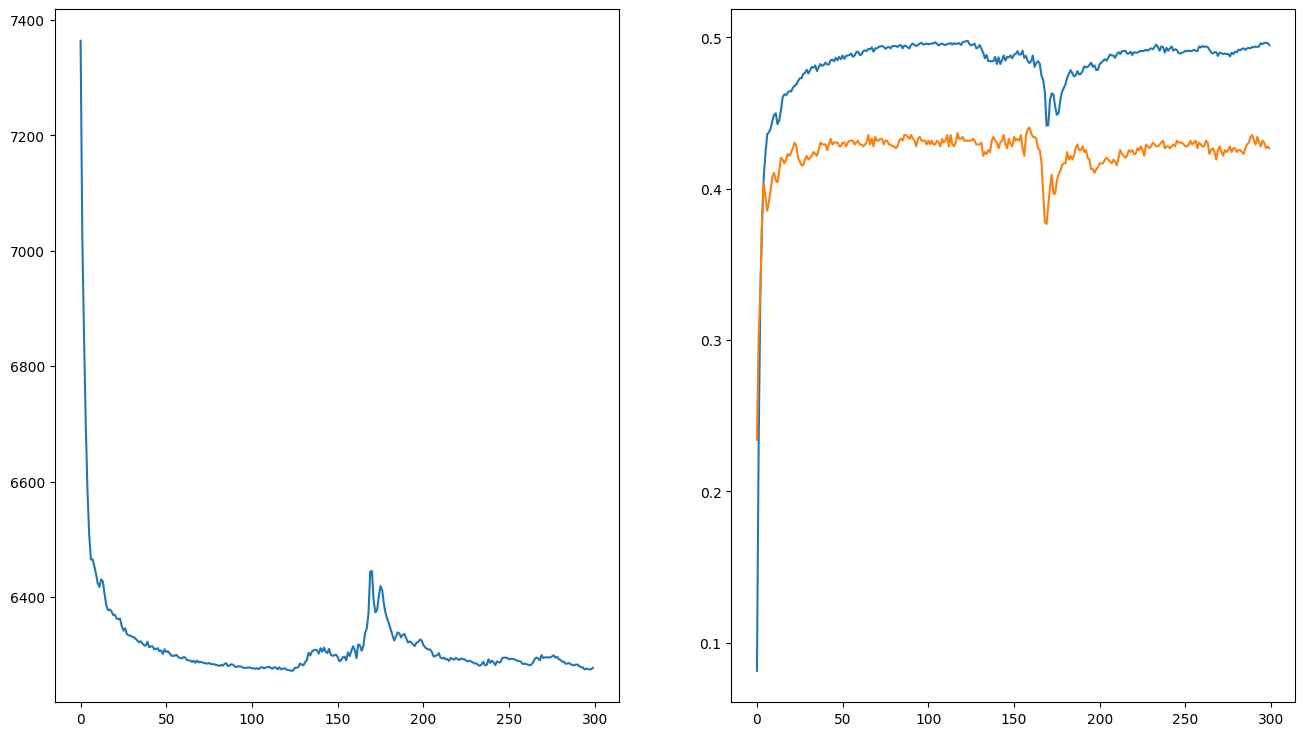

In [ ]:
steps = 1
fig, ax = plt.subplots(1, 2, figsize=(16, 9))
for k, v in model.metrics.items():
	v = v[::steps]
	if k == 'loss':
		ax[0].plot(range(len(v)), v, label=k)
		continue
	ax[1].plot(range(len(v)), v, label=k)

# ax[0].yscale('log')

In [ ]:
from IPython.display import display, clear_output
import numpy as np
import matplotlib.pyplot as plt

# %matplotlib inline

m = 100
n = 100
matrix = np.random.normal(0, 1, size=(m, n))

fig = plt.figure()
ax = fig.add_subplot(111)

# plt.legend()
for i in range(m):
    ax.clear()
    ax.plot(matrix[i, :], label='yons')
    ax.set_ylim((-3, 3))
    ax.legend()
    display(fig)
    clear_output(wait=True)
    plt.pause(0.2)

KeyboardInterrupt: 

In [ ]:
cccc = nn.CrossEntropyLoss()
x = torch.rand(1, 10)

In [ ]:
cccc(x, torch.tensor([2]))

tensor(2.5935)

In [ ]:
cccc(x[0], torch.tensor([0., 0.] + [1.] + [0.] * 7))



tensor(2.5935)

In [ ]:
x.unsqueeze(0)

tensor([[[0.5452, 0.6398, 0.2200, 0.2648, 0.0869, 0.4363, 0.4319, 0.8115,
          0.9201, 0.4437]]])